In [1]:
# Forecasting stock market (S&P500) up or down based on blog and news articles from 2018 Jan to May

## By comparing sentiments in each blog and news item with S&P500 stock price up/down indication and volume
## Dataset from Yahoo Finance and Kaggle competition (blog and news)


In [2]:
import json
from pprint import pprint
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Function to return all json files under each month folder for year 2018
# Only folders with 2018_ in the path name and only .json files

import os
def list_filename(path):
    list_of_files = []
    for root, dirs, files in os.walk(path, topdown=False):
        if '2018_' in root: 
            for name in files:
                if ('.json' in name):  
                    list_of_files.append(os.path.join(root, name))
    return (list_of_files)

In [4]:
# Define variables (some additional parameters for possible future use)
# Find out all json files under monthly folder
# Sentiment was in multiple level on json file, needs to check one by one (person, location, organization)


published = []
text = []
title = []
uuid = []
sentiment = []
result = 0

 
list_of_files = list_filename("./")

for file in list_of_files:
    with open(file, encoding = 'latin-1') as f:
        data = json.load(f)

        published.append(data["published"])
        text.append(data["text"])
        title.append(data["title"])
        uuid.append(data["uuid"])
        tmp = 0

        for i in range(0,len(data.get("entities", {}).get("persons", {}))):
            if data.get("entities", {}).get("persons", {})[i].get("sentiment", {}) == 'negative':
                tmp -= 1
            elif data.get("entities", {}).get("persons", {})[i].get("sentiment", {}) == 'positive':
                tmp += 1
            else:
                tmp
        
        for i in range(0,len(data.get("entities", {}).get("locations", {}))):
            if data.get("entities", {}).get("locations", {})[i].get("sentiment", {}) == 'negative':
                tmp -= 1
            elif data.get("entities", {}).get("locations", {})[i].get("sentiment", {}) == 'positive':
                tmp += 1
            else:
                tmp

        for i in range(0,len(data.get("entities", {}).get("organizations", {}))):
            if data.get("entities", {}).get("organizations", {})[i].get("sentiment", {}) == 'negative':
                tmp -= 1
            elif data.get("entities", {}).get("organizations", {})[i].get("sentiment", {}) == 'positive':
                tmp += 1
            else:
                tmp

        sentiment.append(str(tmp))
        

In [5]:
#Convert lists to pandas Series
published = pd.Series(published)
text = pd.Series(text)
title = pd.Series(title)
uuid = pd.Series(uuid)
sentiment = pd.Series(sentiment)

In [6]:
# Create dataframe from collected data from the json files
Columns=['published','text','title','uuid','sentiment']
df = pd.concat([published, title, text, uuid, sentiment], axis=1)
df.columns=Columns

In [7]:
from datetime import datetime, time
from dateutil.parser import parse
import pandas as pd

# Convert 'published' strings to datetime object (DTime)
df['DTime'] = pd.to_datetime(df.published,format = '%Y-%m-%d', errors='ignore')
df['DTime'] = df['DTime'].apply(lambda x: x.date())

df['sentiment'] = df['sentiment'].apply(lambda x: int(x))

In [8]:
# Checking sentiment content
print('Overall positive sentiments:',df[df['sentiment'] >= 0].sentiment.count())
print('Overall neutral sentiments:',df[df['sentiment'] == 0].sentiment.count())
print('Overall negative sentiments:',df[df['sentiment'] <= 0].sentiment.count())
df.sentiment.describe()
#df.to_pickle('Project_df.pkl')

Overall positive sentiments: 83471
Overall neutral sentiments: 80977
Overall negative sentiments: 303748


count    306242.000000
mean         -1.423299
std           1.273334
min         -12.000000
25%          -2.000000
50%          -1.000000
75%           0.000000
max           7.000000
Name: sentiment, dtype: float64

In [9]:
df.head()

,published,text,title,uuid,sentiment,DTime
0,2018-01-03T15:00:00.000+02:00,Emerging markets are set for an even bigger ra...,17 Hours Ago | 02:56 \nEmerging markets soared...,f86b78623d7a4412c76c1d80ed091184e2c29969,-1,2018-01-03
1,2018-01-03T01:34:00.000+02:00,Cramer reflects on how Trump's actions are fue...,Cramer reflects on how Trump's actions are fue...,c87033fea6042ddc5d9289deebfaa97d4b745e80,-3,2018-01-02
2,2018-01-03T00:59:00.000+02:00,The Wall Street Journal: Peter Thielâs VC fi...,"Published: Jan 2, 2018 5:59 p.m. ET Share \nFe...",8d09d12004eea0019e1d35647a6f0389f8a2a2b5,-2,2018-01-02
3,2018-01-02T15:23:00.000+02:00,Hoda Kotb Will Replace Matt Lauer on NBCâs â...,By Reuters 8:23 AM EST \nTelevision host Hoda ...,73c9950b97e666b2505c8563a483e4dd34b89378,-4,2018-01-02
4,2018-01-01T11:03:00.000+02:00,UK's Compass says new CEO to start Jan 1 after...,"January 1, 2018 / 8:56 AM / Updated 5 hours ag...",ff93fea93e398d778faead29faabf47d7e2cbf81,-2,2018-01-01


In [10]:
# Calculate sum of sentiment based on each DTime unique value i.e. date
dfv2 = df.groupby("DTime").sentiment.sum()

In [11]:
dfv2.describe()

count     167.000000
mean    -2610.023952
std      1821.588407
min     -7310.000000
25%     -4222.500000
50%     -2758.000000
75%      -720.500000
max         0.000000
Name: sentiment, dtype: float64

In [12]:
#Remove 2017 information and create index
dfv2 = dfv2[dfv2.index >= (pd.to_datetime("2018-01-01")).date()]
dfv2 = dfv2.reset_index()

In [13]:
#Read S&P500 file
df_y = pd.read_csv('GSPC.csv')

In [14]:
# Convert Date strings to datetime object (dtime)
df_y['dtime'] = pd.to_datetime(df_y.Date)
#Remove 2017 information
df_y = df_y[df_y.dtime >= (pd.to_datetime("2018-01-01")).date()]
df_y = df_y.reset_index()
df_y.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,dtime
0,16,1/2/2018,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3367250000,2018-01-02
1,17,1/3/2018,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3538660000,2018-01-03
2,18,1/4/2018,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3695260000,2018-01-04
3,19,1/5/2018,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3236620000,2018-01-05
4,20,1/8/2018,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3242650000,2018-01-08


In [15]:
#Convert to date and merge dataframes based on DTime and formatted_date
df_y['formatted_date'] = df_y['dtime'].apply(lambda x: x.date())
dfv2 = dfv2.merge(df_y, 'right', left_on=dfv2.DTime, right_on=df_y.formatted_date)
dfv2.tail()

,key_0,DTime,sentiment,index,Date,Open,High,Low,Close,Adj Close,Volume,dtime,formatted_date
99,2018-05-24,2018-05-24,-4190,115,5/24/2018,2730.939941,2731.969971,2707.379883,2727.760010,2727.760010,3256030000,2018-05-24,2018-05-24
100,2018-05-25,2018-05-25,-2413,116,5/25/2018,2723.600098,2727.360107,2714.989990,2721.330078,2721.330078,2995260000,2018-05-25,2018-05-25
101,2018-05-29,2018-05-29,-2321,117,5/29/2018,2705.110107,2710.669922,2676.810059,2689.860107,2689.860107,3736890000,2018-05-29,2018-05-29
102,2018-05-30,2018-05-30,-2908,118,5/30/2018,2702.429932,2729.340088,2702.429932,2724.010010,2724.010010,3561050000,2018-05-30,2018-05-30
103,2018-05-31,2018-05-31,-2068,119,5/31/2018,2720.979980,2722.500000,2700.679932,2705.270020,2705.270020,4235370000,2018-05-31,2018-05-31


In [16]:
# Check if S&P500 is going up or down
up_down = [1]
                                                         
for i in range(0,(len(df_y.Close)-1)):
    if df_y.Close[i] < df_y.Close[i+1]:
        up_down.append(1)
    elif df_y.Close[i] == df_y.Close[i+1]:
        up_down.append(0)
    elif df_y.Close[i] > df_y.Close[i+1]:
        up_down.append(-1)
    

In [17]:
# Store in result
dfv2['result'] = up_down

In [18]:
#Only keep needed columns (sentiment, Volume and result)
df_final = dfv2[['sentiment','Volume','result' ]]
df_final.head(5)

,sentiment,Volume,result
0,-1466,3367250000,1
1,-2081,3538660000,1
2,-2124,3695260000,1
3,-1818,3236620000,1
4,-2985,3242650000,1


In [19]:
import matplotlib.pyplot as plt

# Plot timeline with both Closing price and sentiment value from blogs&news
fig = plt.figure()
host = fig.add_subplot(111)
par1 = host.twinx()
host.set_ylim(-7500, 100)
par1.set_ylim(2500, 3000)
host.set_xlabel("Date")
host.set_ylabel("Sentiment")
par1.set_ylabel("Close")
color1 = 'blue' 
color2 = 'red' 
host.plot(dfv2.DTime, dfv2.sentiment, color=color1,label="Sentiment")
par1.plot(df_y.dtime, df_y.Close, color=color2, label="Close")
plt.legend()
plt.show();

<Figure size 640x480 with 2 Axes>

In [20]:
# Normalizing df_final
from sklearn import preprocessing
float_array = df_final.values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
df_normalized = pd.DataFrame(scaled_array,columns = ['sentiment','Volume','result'])
print("Dataframe shape: ",df_normalized.shape,"\n") 
print(df_normalized[0:5])

Dataframe shape:  (104, 3) 

   sentiment    Volume  result
0   1.000000  0.166575     1.0
1   0.894764  0.223166     1.0
2   0.887406  0.274867     1.0
3   0.939767  0.123448     1.0
4   0.740075  0.125439     1.0


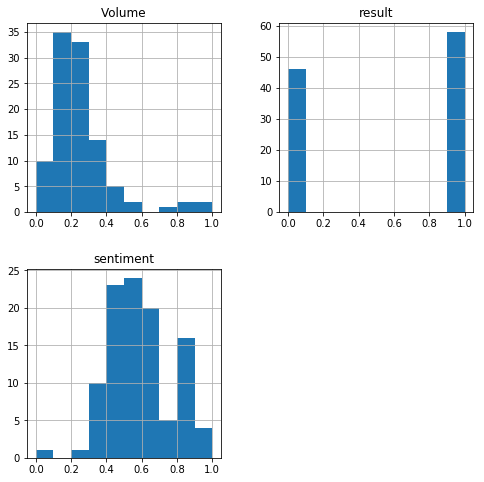

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (8,8))
ax = fig.gca()
#df_final.hist(ax = ax);
df_normalized.hist(ax = ax);

In [22]:
def correlation_matrix(data):

    from matplotlib import cm as cm
    import seaborn as sns

    fig = plt.figure(figsize=(3,3))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    labels = ['Volume','Sentiment','Result']
    cax = ax1.imshow(data.corr(), interpolation="nearest", cmap=cmap)
    ax1.set_xticks(np.arange(len(data.corr())))
    ax1.set_yticks(np.arange(len(data.corr())))
    ax1.set_xticklabels(labels,fontsize=8)
    ax1.set_yticklabels(labels,fontsize=8)

    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()
    


In [23]:
#Print out correlation values
df_normalized.corr()

,sentiment,Volume,result
sentiment,1.000000,-0.150129,-0.034209
Volume,-0.150129,1.000000,-0.151199
result,-0.034209,-0.151199,1.000000


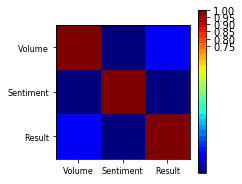

In [24]:
#Print correlation matrix
correlation_matrix(df_normalized) 

In [25]:
# Seperate X and y from dataframe
X = df_normalized.drop('result',axis=1) 
y = df_normalized['result']


In [26]:
# Split data to training and test
from sklearn.model_selection import train_test_split
# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print("X_train shape: ",X_train.shape) # 78 rows, 2 columns
print("y_train shape: ",y_train.shape) # 78 rows, 1 column
print("X_test shape: ",X_test.shape) # 26 rows, 2 columns
print("y_test shape: ",y_test.shape) # 26 rows, 1 column

X_train shape:  (78, 2)
y_train shape:  (78,)
X_test shape:  (26, 2)
y_test shape:  (26,)


In [27]:
# Define 9 different classification training models
# !pip install xgboost #Uncomment this if xgboost not installed yet in your machine
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


d_models = {"Logistic Regression": LogisticRegression(),
            "Gaussian Naive Bayes": GaussianNB(),
            "K Nearest Neighbor": KNeighborsClassifier(n_neighbors=5),
#            "XG Boost": XGBClassifier(),
            "SVM Classifier": SVC(),
            "SGD Classifier":OneVsRestClassifier(SGDClassifier()),
            "MLP Neural network": MLPClassifier(),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "DecisionTree": DecisionTreeClassifier(),}
models_list = d_models.keys()
print(models_list)

dict_keys(['Logistic Regression', 'Gaussian Naive Bayes', 'K Nearest Neighbor', 'SVM Classifier', 'SGD Classifier', 'MLP Neural network', 'Random Forest', 'DecisionTree'])


In [28]:
# suppress warning on below model predictions
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Loop through all classification models 
    for classification_model in models_list:
        #Train the model
        model = d_models[classification_model]
        model.fit(X_train,y_train)
        print(model)
        # make predictions for test data
        expected = y_test
        predicted = model.predict(X_test)
        print(metrics.classification_report(expected, predicted))
        print(metrics.confusion_matrix(expected, predicted))
        print("Accuracy for test data:",metrics.accuracy_score(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.58      1.00      0.73        15

   micro avg       0.58      0.58      0.58        26
   macro avg       0.29      0.50      0.37        26
weighted avg       0.33      0.58      0.42        26

[[ 0 11]
 [ 0 15]]
Accuracy for test data: 0.5769230769230769
GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.56      0.93      0.70        15

   micro avg       0.54      0.54      0.54        26
   macro avg       0.28      0.47      0.35        26
weighted avg       0.32      0

# Conclusion:
## Based on the current data from S&P500 and blogs&news there is not enough correclation to estimate how next day S&P500 reacts

# Possible future next steps:
## - possibly widen analysis of blog/news dates vs. stock changes
## - check if seperating sentiments will give any better results
## - possibly check what other data is available from the json files
